In [2]:
# initialization
import numpy as np
import random

# importing Qiskit
from qiskit import Aer
from qiskit import QuantumCircuit, transpile
from qiskit import *
from qiskit.circuit.library import *
from qiskit.providers.aer import *
import matplotlib.pyplot as plt

# import basic plot tools
from qiskit.visualization import plot_histogram

In [3]:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

In [4]:
def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

In [5]:
aer_sim = AerSimulator(method='statevector', device='CPU')
aer_sim_GPU = AerSimulator(method='statevector', device='GPU')

In [6]:
qubits_lim = 28
qubits_list = []
time_thrust= []
time_cuStateVec= []
time_CPU = []

In [7]:
for qubits in range (15, qubits_lim):
    qubits_list.append(qubits)

    oracle_gate = dj_oracle('balanced', qubits)
    dj_circuit = dj_algorithm(oracle_gate, qubits)
    transpiled_dj_circuit = transpile(dj_circuit, aer_sim)
    result_CPU = aer_sim.run(transpiled_dj_circuit).result()
    time_CPU.append(float(result_CPU.to_dict()['results'][0]['time_taken']))

In [8]:
for qubits in range (15, qubits_lim):
    oracle_gate = dj_oracle('balanced', qubits)
    dj_circuit = dj_algorithm(oracle_gate, qubits)
    transpiled_dj_circuit_GPU = transpile(dj_circuit, aer_sim_GPU)
    result_GPU = aer_sim_GPU.run(transpiled_dj_circuit_GPU, cuStateVecEnable = False).result()
    time_thrust.append(float(result_GPU.to_dict()['results'][0]['time_taken']))

In [9]:
for qubits in range (15, qubits_lim):
    oracle_gate = dj_oracle('balanced', qubits)
    dj_circuit = dj_algorithm(oracle_gate, qubits)
    transpiled_dj_circuit_GPU = transpile(dj_circuit, aer_sim_GPU)
    result_GPU = aer_sim_GPU.run(transpiled_dj_circuit_GPU, cuStateVecEnable = True).result()
    time_cuStateVec.append(float(result_GPU.to_dict()['results'][0]['time_taken']))

Text(0, 0.5, 'Simulation time (s)')

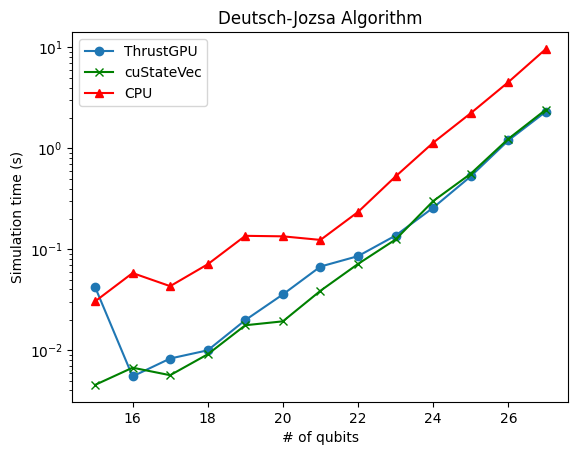

In [10]:
plt.yscale("log")
plt.title('Deutsch-Jozsa Algorithm')
plt.plot(qubits_list, time_thrust, marker="o", label='ThrustGPU')
plt.plot(qubits_list, time_cuStateVec, 'g', marker="x", label='cuStateVec')
plt.plot(qubits_list, time_CPU, 'r', marker="^", label='CPU')
plt.legend()
plt.xlabel("# of qubits")
plt.ylabel("Simulation time (s)")